#  Sklearn Pipeline

For 
- a)-Cross validate a process that may include preprocessing and model building
- b)- Use GridSearch or Random Search that allows tuning of parameters and preprocessing steps

### Bonus

One hot encoder & column transformer concepts

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
! pip install version_information

In [4]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,sklearn,numpy,seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.25.3
sklearn 0.21.3
numpy 1.17.4
seaborn 0.9.0
matplotlib 3.1.1
Wed Nov 13 18:44:18 2019 UTC

# 2)- Reading Dataset

Titanic dataset 

In [0]:
df = pd.read_csv('titanic.csv')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df.shape

(891, 12)

In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 2a)- Checking missing values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


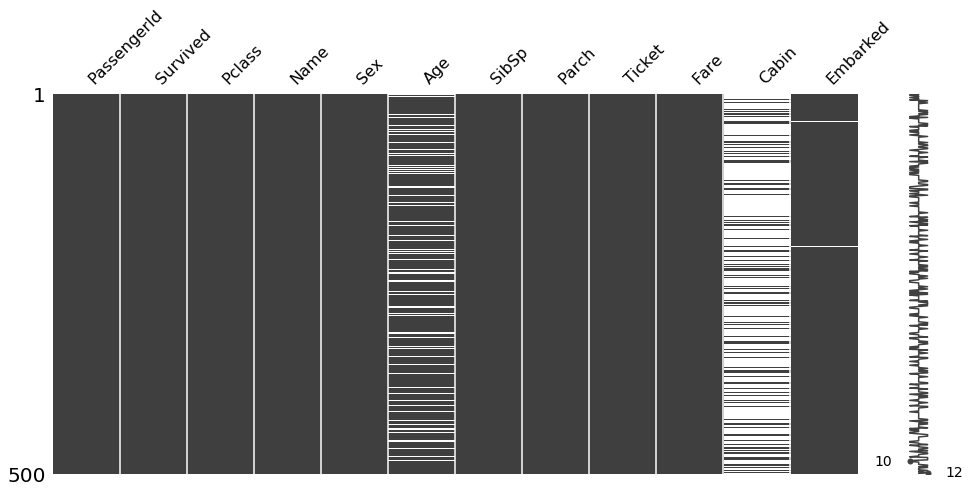

In [11]:
import missingno as msno

msno.matrix(df.sample(500),
            figsize=(16, 7),
            width_ratios=(15, 1))

In [12]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 2b)- Feature of Interest

In [13]:
# taking key features...
df.loc[:, ['Survived', 'Pclass', 'Sex', 'Embarked']] # taking all rows and keeping columns with given names

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S
...,...,...,...,...
886,0,2,male,S
887,1,1,female,S
888,0,3,female,S
889,1,1,male,C


We kept all rows and focussed our features to given. However, we have missing values in "Embarked"

In [0]:
df = df.loc[df.Embarked.notna(), ['Survived', 'Pclass', 'Sex', 'Embarked']]

In [15]:
df.shape

(889, 4)

We removed two missing entities from our dataset

In [16]:
df.head()

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S


In [17]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Embarked    0
dtype: int64

# 3)- Cross-validate a model with one feature

In [0]:
X = df.loc[:, ['Pclass']]
y = df.Survived

In [19]:
X[:5]

,Pclass
0,3
1,1
2,3
3,1
4,3


In [20]:
print(X.shape)
print(y.shape)

(889, 1)
(889,)


In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()

0.6783406335301212

**Null Accuracy**

In [23]:
y.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

# 4)- Cross-validate a model with Multiple features

### 4.1)- Encode categorical features

In [0]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

In [25]:
table_dtype = _tbl_dtype(df)
table_dtype

,Data Type
Survived,int64
Pclass,int64
Sex,object
Embarked,object


In [0]:
# dummy encoding of categorical features
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

In [27]:
ohe.fit_transform(df[['Sex']])

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [28]:
ohe.categories_

[array(['female', 'male'], dtype=object)]

In [29]:
ohe.fit_transform(df[['Embarked']])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [30]:
ohe.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [31]:
# in one-go
ohe.fit_transform(df[['Sex', 'Embarked']])

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

### 4.2)- Column transformation

In [0]:
X = df.drop('Survived', axis='columns')

In [33]:
X.columns

Index(['Pclass', 'Sex', 'Embarked'], dtype='object')

In [0]:
# use when different features need different preprocessing
from sklearn.compose import make_column_transformer

In [0]:
# for encoding 
column_trans = make_column_transformer(
    (OneHotEncoder(), ['Sex', 'Embarked']),
    remainder='passthrough') # passthrough for pclass variable as it will not be effected by our one-hot encoding

**to see details**

In [36]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               n_values=None, sparse=True),
                                 ['Sex', 'Embarked'])],
                  verbose=False)

In [37]:
column_trans.fit_transform(X)

array([[0., 1., 0., 0., 1., 3.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 3.],
       ...,
       [1., 0., 0., 0., 1., 3.],
       [0., 1., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 3.]])

**1st two columns are for feature "sex", next 3 columns are for "Embarked" and last column shows pclass which is same as of our original dataset**

### 4.3)- Create Pipeline

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

**pipeline is like chaining processes together**

We shall use our preprocessing step of column transformation and then we shall use our logistic classification model.

In [0]:
from sklearn.pipeline import make_pipeline

In [0]:
pipe = make_pipeline(column_trans, logreg)

In [41]:
# cross-validate the entire process
# thus, preprocessing occurs within each fold of cross-validation
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7727924839713071

# 5)- Make predictions

In [0]:
# create random sample from given training data
X_new = X.sample(5, random_state=99)

In [43]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['Sex', 'Embarked'])],
                      

In [44]:
pipe.predict(X_new)

array([1, 0, 1, 1, 0])

# Full Pipeline

having one hot encoding + column transformation

In [0]:
df = pd.read_csv('http://bit.ly/kaggletrain')
df = df.loc[df.Embarked.notna(), ['Survived', 'Pclass', 'Sex', 'Embarked']]
X = df.drop('Survived', axis='columns')
y = df.Survived

In [46]:
print(X.shape)
print(y.shape)

(889, 3)
(889,)


In [0]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['Sex', 'Embarked']),
    remainder='passthrough')
logreg = LogisticRegression(solver='lbfgs')

In [0]:
pipe = make_pipeline(column_trans, logreg)

In [49]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7727924839713071

In [0]:
X_new = X.sample(5, random_state=99)

In [51]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['Sex', 'Embarked'])],
                      

In [52]:
pipe.predict(X_new)

array([1, 0, 1, 1, 0])